# Машинное обучение, ВМК МГУ

## Практическое задание 3

### О задании

Задание состоит из трех независимых разделов, посвященных bias-variance decomposition, решающим деревьям и композициям алгоритмов. Эти разделы можно выполнять в любом порядке. В каждом разделе вам предложена одна или две задачи, которые, в свою очередь, делятся на пункты. Баллы даются за выполнение пунктов, причем в рамках одной задачи пункты, как правило, зависимы (нельзя решить следующий, не решив предыдущего). Пункты могут быть двух видов: написать скрипт или ответить на вопросы. Задачи в рамках одного раздела рекомендуется решать в том порядке, в котором они даны в задании. В разных задачах используются разные наборы данных, все наборы взяты из репозитория UCI или из соревнования с платформы kaggle. 

Задание направлено на более глубокое ознакомление с тем, как работают решающие деревья, случайные леса и как устроено разложение на смещение и разброс. Кроме того, задание предполагает проведение экспериментов и анализ их результатов (мини-исследования). 

### Формат сдачи
Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-02-Username.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-02-IvanovIvan.ipynb). Приложите модули с кодом logreg.py и заархивируйте оба файла вместе в zip формат. Имя архива должно быть homework-practice-02-Username.zip)
Далее отправьте этот файл на ml.cmc.msu@gmail.com
Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

* Ссылка на посылку в Яндекс.Контесте:
* Максимальная оценка: 

### I. Разложение ошибки на смещение и разброс
#### Теоретическое вступление
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar x} f(\bar x)$ функции от многомерной случайной величины $\bar x = (x_1, \dots, x_d)$, $\bar x \sim p(\bar x)$, можно сгенерировать выборку из распределения $p(\bar x)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar x} f(x) = \int f(\bar x) p(\bar x) d \bar x \approx \frac 1 m \sum_{i=1}^m f(\bar x_i), \, \bar x_i \sim p(\bar x), i = 1, \dots, m.$$

Для оценки многомерных интегралов ($d > 1$) объекты лучше генерировать, следуя специальным схемам, чтобы адекватно оценивать значение интеграла в областях высокой плотности. Мы не будем так усложнять задачу, а просто будем генерировать $\bar x_i$ независимо.

In [1]:
import numpy as np

Например, оценим $\mathbb{E}_x x^2,$ $x \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_x x^2 = \sigma^2 + \mu^2 = 34$):

In [3]:
x = np.random.normal(loc=5, scale=3, size=1000)
(x**2).mean()

33.57113270589533

Или посчитаем многомерный интеграл $\mathbb{E}_{\bar x} \bar x^T \bar x = \mathbb{E}_{\bar x} \sum_{i=1}^d x_i^2$, $\bar x \sim \mathcal{N}(\bar \mu=(1, \dots, 1), \Sigma=I)$ при $d = 10$ (аналитический ответ 20):

In [4]:
d = 10
X = np.random.multivariate_normal(np.ones(10), np.eye(10), size=1000)
(X**2).sum(axis=1).mean()

19.473317213771807

Чтобы оценить интеграл по выборке, можно сгенерировать несколько выборок, вычислить на них значение функции и усреднить. Например, для интеграла $\mathbb{E}_X [\mu(X)(x)]$ генерируются выборки $X_1, \dots, X_m$, на каждой из них обучается алгоритм $\mu$ и делается предсказание для объекта $x$.

#### Практическая часть
##### Задача 1. Построение "среднего" алгоритма $\mathbb{E}_X [\mu(X)]$
В этом задании вам нужно построить графики, демонстрирующие, как алгоритм $\mathbb{E}_X [\mu(X)]$ аппроксимирует истинную зависимость в данных и как он меняется в зависимости от гиперпараметров метода обучения.

In [5]:
from matplotlib import pyplot as plt
%matplotlib inline

In [6]:
def f(x):
    return np.sin(x)   # истинная зависимость в данных
sample_size = 100      # длина выборки
samples_num = 20       # количество выборок
linspace = np.linspace(0, 7, 1000)  # точки для построения графиков

__1. (0.3 балла)__
1. Сгенерируйте выборку $x$ из одномерного экспоненциального распределения (np.random.exponential) длины sample_size.
1. Создайте вектор целевых переменных $y$ как сумму $f(x)$ и случайного шума, сгенерированного из равномерного распределения на отрезке $[-1, 1]$ (np.random.uniform).
1. Обучите DecisionTreeRegressor с параметрами по умолчанию на полученной выборке и сделайте предсказания для объектов из linspace.
1. Постройте два графика на одном рисунке: $f(x)$ и зависимость, восстановленную решающим деревом.

    Рекомендация: не забудьте, что все методы обучения в sklearn требуют на вход двумерную матрицу объекты-признаки. Сделать такую из одномерного вектора можно добавлением мнимых осей (np.newaxis).

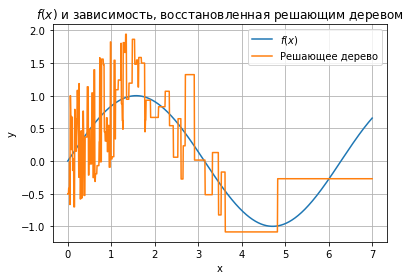

In [7]:
from sklearn.tree import DecisionTreeRegressor
X = np.random.exponential(size=sample_size)
y = f(X) + np.random.uniform(low=-1.0, high=1.0, size=sample_size)
tree = DecisionTreeRegressor()
tree.fit(X[:,np.newaxis], y)
score = tree.predict(linspace[:,np.newaxis])
ax = plt.axes()
plt.title(
    "$f(x)$ и зависимость, восстановленная решающим деревом")
plt.plot(linspace, f(linspace), label=u"$f(x)$")
plt.plot(linspace, score, label=u"Решающее дерево")
ax.set_xlabel(u"x")
ax.set_ylabel(u"y")
ax.grid()
ax.legend()

__2. (0.3 балла)__

Повторите первые 3 шага, описанные выше, samples_num раз. На одном графике для каждого обученного решающего дерева визуализируйте восстановленную им зависимость (рекомендуется все такие линии рисовать полупрозрачными и серым цветом: plt.plot(...... color="gray", alpha=0.5)).  На этом же графике изобразите истинную зависимость f(x) (красным цветом: color="red") и усредненную по всем деревьям восстановленную зависимость (черным цветом: color="black").    

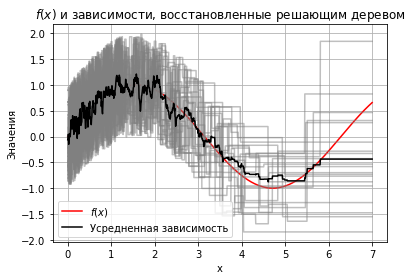

In [8]:
ax = plt.axes()
plt.title(
    "$f(x)$ и зависимости, восстановленные решающим деревом")
plt.plot(linspace, f(linspace), label=u"$f(x)$", color="red")
ax.set_xlabel(u"x")
ax.set_ylabel(u"Значения")
mean_score = np.zeros(linspace.shape)
for n in range(samples_num):
    X = np.random.exponential(size=sample_size)
    y = f(X) + np.random.uniform(low=-1.0, high=1.0, size=sample_size)
    tree = DecisionTreeRegressor()
    tree.fit(X[:,np.newaxis], y)
    score = tree.predict(linspace[:,np.newaxis])
    mean_score += score
    plt.plot(linspace, score, color="gray", alpha=0.5)
mean_score /= samples_num
plt.plot(linspace, mean_score, label=u"Усредненная зависимость", color="black")
ax.grid()
ax.legend()

__3. (0.1 балла):__
Повторите предыдущий пункт, установив максимальную глубину решающего дерева равной 2, а затем равной 4. Таким образом, у вас получится еще два графика. __Избегайте копипасты кода! Сделайте функцию, параметризованную максимальной глубиной дерева, которая отрисовывает необходимые картинки!__

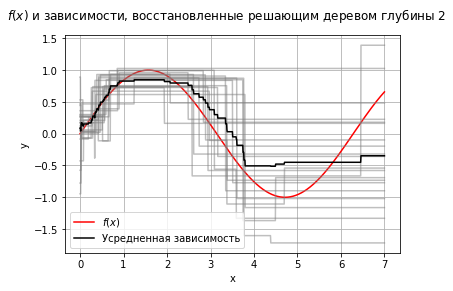

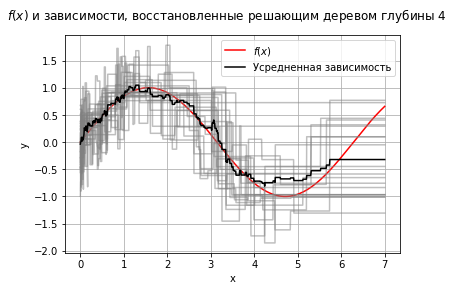

In [9]:
def plot_with_depth(depth=None):
    fig = plt.figure()
    ax = plt.axes()
    fig.suptitle(
        "$f(x)$ и зависимости, восстановленные решающим деревом глубины {}".format(depth))
    plt.plot(linspace, f(linspace), label=u"$f(x)$", color="red")
    ax.set_xlabel(u"x")
    ax.set_ylabel(u"y")
    mean_score = np.zeros(linspace.shape)
    for n in range(samples_num):
        X = np.random.exponential(size=sample_size)
        y = f(X) + np.random.uniform(low=-1.0, high=1.0, size=sample_size)
        tree = DecisionTreeRegressor(max_depth=depth)
        tree.fit(X[:,np.newaxis], y)
        score = tree.predict(linspace[:,np.newaxis])
        mean_score += score
        plt.plot(linspace, score, color="gray", alpha=0.5)
    mean_score /= samples_num
    plt.plot(linspace, mean_score, label=u"Усредненная зависимость", color="black")
    ax.grid()
    ax.legend()

plot_with_depth(2)
plot_with_depth(4)

__4. (0.3 балла)__ Что можно сказать о смещении решающих деревьев, исходя из проведенного эксперимента? В каких из трех рассмотренных случаев (без ограничения на глубину дерева и с ограничением 2 и 4) можно утверждать, что смещение решающего дерева близко к нулю?

**Ответ:** При увеличении глубины решающего дерева его смещение уменьшается. В этом случае можно утверждать, что глубине дерева 4 смещение решающего дерева наиболее близо к 0.

#### Задача 2. Приближенное оценивание смещения и разброса
Реализуем стохастическую процедуру оценивания смещения и разброса алгоритма.

Будем считать, что каждый объект представлен одним признаком, сгенерированным из некоторого распределения, а значение целевой переменной на этом объекте — это сумма истинного значения функции на объекте + шумовая компонента, также сгенерированная из некоторого распределения.

__5. (1 балл) __ 

Реализуйте функции compute_bias_variance и compute_bias_variance_fixed_samples из модуля hw3code.py

In [10]:
def compute_bias_variance(regressor, dependence_fun, x_generator=np.random.uniform, noise_generator=np.random.uniform,
                          sample_size=300, samples_num=300, objects_num=200, seed=1234):
    """
    После генерации всех необходимых объектов, должна вызываться функция compute_bias_variance_fixed_samples.

    Рекомендации:
    * Создайте вектор объектов для оценивания интеграла по $x$, затем вектор зашумленных правильных ответов.
      Оцените мат. ожидание шума с помощью генерации отдельной шумовой выборки длины objects_num.
    * Проверить правильность реализации можно на примерах, которые разбирались на семинаре и в домашней работе.

    :param regressor: объект sklearn-класса, реализующего регрессионный алгоритм (например, DecisionTreeRegressor,
     LinearRegression, Lasso, RandomForestRegressor ...)
    :param dependence_fun: функция, задающая истинную зависимость в данных. Принимает на вход вектор и возвращает вектор
     такой же длины. Примеры: np.sin, lambda x: x**2
    :param x_generator: функция, генерирующая одномерную выборку объектов и имеющая параметр size (число объектов в
     выборке). По умолчанию np.random.uniform
    :param noise_generator: функция, генерирующая одномерную выборку шумовых компонент (по одной на каждый объект) и
     имеющая параметр size (число объектов в выборке). По умолчанию np.random.uniform
    :param sample_size: число объектов в выборке
    :param samples_num: число выборок, которые нужно сгенерировать, чтобы оценить интеграл по X
    :param objects_num: число объектов, которые нужно сгенерировать, чтобы оценить интеграл по x
    :param seed: seed для функции np.random.seed

    :return bias: смещение алгоритма regressor (число)
    :return variance: разброс алгоритма regressor (число)
    """
    np.random.seed(seed)
    X_l = x_generator(size=(samples_num, sample_size))
#     y_l = dependence_fun(X_l) + noise_generator(size=(samples_num, sample_size))
    noise = noise_generator(size=(samples_num, sample_size))
    noise_X = noise_generator(size=objects_num)
    mean_noise = np.mean(noise)
    bias, variance = compute_bias_variance_fixed_samples(regressor, dependence_fun,
                                                         X_l, noise_X, noise, mean_noise)
    return bias, variance


def compute_bias_variance_fixed_samples(regressor, dependence_fun, samples, objects, noise, mean_noise):
    """
    В качестве допущения, будем оценивать $E_X\left[\mu(X)\right](x)$ как средний ответ на $x$ из samples_num
    алгоритмов, обученных на своих подвыборках $X$

    Рекомендации:
    * $\mathbb{E}[y|x]$ оценивается как сумма правильного ответа на объекте и мат. ожидания шума
      $\mathbb{E}_X [\mu(X)]$ оценивается как в предыдущей задаче: нужно обучить regressor на samples_num выборках длины
       sample_size и усреднить предсказания на сгенерированных ранее объектах.

    :param regressor: объект sklearn-класса, реализующего регрессионный алгоритм (например, DecisionTreeRegressor,
     LinearRegression, Lasso, RandomForestRegressor ...)
    :param dependence_fun: функция, задающая истинную зависимость в данных. Принимает на вход вектор и возвращает вектор
     такой же длины. Примеры: np.sin, lambda x: x**2
    :param samples: samples_num выборок длины sample_size для оценки интеграла по X
    :param objects: objects_num объектов для оценки интеграла по x
    :param noise: шумовая компонента размерности (samples_num, sample_size)
    :param mean_noise: среднее шумовой компоненты

    :return bias: смещение алгоритма regressor (число)
    :return variance: разброс алгоритма regressor (число)
    """
    mu = np.zeros((samples.shape[0], objects.shape[0]))
    y = dependence_fun(samples) + noise
    E_X_mu = np.zeros(objects.shape[0])
    for i in range(samples.shape[0]):
        x = samples[i]
        regressor.fit(x[:, np.newaxis], y[i])
        score = regressor.predict(objects[:, np.newaxis])
        mu[i] = score
        E_X_mu += score
    E_X_mu /= samples.shape[0]
    E_yORx = mean_noise + dependence_fun(objects)
    bias = ((E_X_mu - E_yORx)**2).mean()
    variance = ((mu - E_X_mu)**2).mean()
    return bias, variance

__6. (0.4 балла)__ 

Пусть истинная зависимость данных задается функцией $5\sin (10 x)$, а значения признаков и шум генерируются из одного и того же распределения. Будем пробовать 4 разных распределения и сравнивать 4 регрессионных алгоритма (см. таблицы ниже). Необходимо в каждую ячейку датафреймов bias и variance записать записать соответственно смещение и разброс, рассчитанные для алгоритма, задаваемого строкой таблицы, и генератора случайных чисел, задаваемого столбцом. Остальные параметры функции compute_bias_variance оставьте по умолчанию.

In [16]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier

In [17]:
regressors = [LinearRegression(), 
              DecisionTreeRegressor(), 
              RandomForestRegressor(),
              GradientBoostingRegressor()]
generators = [lambda size: np.random.normal(0, 0.3, size=size), 
              lambda size: np.random.exponential(0.3, size=size), 
              lambda size: np.random.uniform(-1, 1, size=size),
              lambda size: np.random.uniform(0, 1, size=size)]

In [39]:
df_bias = pd.DataFrame(columns=["normal(0, 0.3)", "exponential(0.3)", "uniform(-1, 1)", "uniform(0, 1)"],
                       index=["LinearRegression", "DecisionTree", "RandomForest", "GradientBoosting"])
df_variance = pd.DataFrame(columns=df_bias.columns, index=df_bias.index)

In [20]:
from importlib import reload
import hw3code

reload(hw3code)

<module 'hw3code' from '/Users/anoshin_alexey/Desktop/MachineLearning/Tasks/Task3/hw3code.py'>

In [40]:
function = lambda x: 5*np.sin(10*x)
i = 0
for reg in regressors:
    j = 0
    for gen in generators:
        bias, variance = compute_bias_variance(reg, function, x_generator=gen, noise_generator=gen)
        df_bias.iloc[i, j] = bias
        df_variance.iloc[i, j] = variance
        j += 1
    i +=1

In [22]:
df_bias

,"normal(0, 0.3)",exponential(0.3),"uniform(-1, 1)","uniform(0, 1)"
LinearRegression,12.1609,7.12199,11.744,12.0557
DecisionTree,0.0766306,0.0825574,0.00155487,0.000388934
RandomForest,0.0846314,0.125646,0.00167372,0.000341246
GradientBoosting,0.0776251,0.0860017,0.0115844,0.000922377


In [23]:
df_variance

,"normal(0, 0.3)",exponential(0.3),"uniform(-1, 1)","uniform(0, 1)"
LinearRegression,0.088641,0.0725084,0.0790963,0.0577688
DecisionTree,0.174574,0.228285,0.362733,0.0900954
RandomForest,0.102314,0.134275,0.197171,0.0490146
GradientBoosting,0.116974,0.160309,0.144254,0.0391881


In [41]:
df_variance['a'] = df_variance['normal(0, 0.3)'].rank() 
df_variance['b'] = df_variance['exponential(0.3)'].rank()
df_variance['c'] = df_variance['uniform(-1, 1)'].rank()
df_variance['d'] = df_variance['uniform(0, 1)'].rank()

df_variance

,"normal(0, 0.3)",exponential(0.3),"uniform(-1, 1)","uniform(0, 1)",a,b,c,d
LinearRegression,0.088641,0.0725084,0.0790963,0.0577688,1.0,1.0,1.0,3.0
DecisionTree,0.174574,0.228285,0.362733,0.0900954,4.0,4.0,4.0,4.0
RandomForest,0.102314,0.134275,0.197171,0.0490146,2.0,2.0,3.0,2.0
GradientBoosting,0.116974,0.160309,0.144254,0.0391881,3.0,3.0,2.0,1.0


__7. (0.6 балла)__  

Проанализируйте полученные таблицы. Ответьте на вопросы:
* Отранжируйте алгоритмы в порядке увеличения разброса (если какие-то алгоримты в разных случаях ранжируются по-разному, поставьте их на одну ступень). Согласуется ли полученный результат с теоретическими рассуждениями из лекций (поясните, почему да или нет)?
* Можно ли сказать, что смещение и разброс алгоритма определяются только самим алгоритмом и не зависят от вероятностной модели данных, к которым этот алгоритм применяется (поясните, почему да или нет)? 
* Для каких распределений смещение решающих деревьев велико (по сравнению с другими распределениями)? Как вы думаете, почему так происходит (какие особенности этих распределений приводят к большому смещению)?

**Ответ:** 1) В целом данные результаты подтверждает теорию, описанную в лекциях: самый маленький разброс данных достигается на линейной регрессии, в то время как самый большой разброс всегда достигается на решающих деревьях

2)Нет нельзя, поскольку анализируя полученные результаты можно увидеть их зависимость от заданной вероятностоной модели данных

3) Для нормального и экспоненциального распределения. Так происходит потому, что выборка неограниченна каким-либо интервалом, в том числе присутствуют удаленные объекты, на которых ошибка увеличивается

### II. Решающие деревья своими руками

#### Задача 3.
В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__9. (0.5 балла)__

Реализуйте функцию find_best_split из модуля hw3code.py

In [24]:
def find_best_split(feature_vector, target_vector):
    """
    Под критерием Джини здесь подразумевается следующая функция:
    $$Q(R) = -\frac {|R_l|}{|R|}H(R_l) -\frac {|R_r|}{|R|}H(R_r)$$,
    $R$ — множество объектов, $R_l$ и $R_r$ — объекты, попавшие в левое и правое поддерево,
     $H(R) = 1-p_1^2-p_0^2$, $p_1$, $p_0$ — доля объектов класса 1 и 0 соответственно.

    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини нужно выбирать минимальный порог.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)

    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    if np.all(feature_vector == feature_vector[0]):
        return -np.inf, -np.inf, -np.inf, -np.inf
    length = len(feature_vector)
    thresholds = np.array([])
    ginis = np.array([])
#     sorted_idxs = np.argsort(feature_vector)
#     sorted_vector = feature_vector[sorted_idxs]
#     sorted_target = target_vector[sorted_idxs]
    usorted_vector = np.unique(feature_vector)
    i = np.arange(1, len(usorted_vector))
    thresholds = 0.5*(usorted_vector[i] + usorted_vector[i-1])
    left = np.less(feature_vector, thresholds.reshape(len(thresholds), 1))
    right = np.greater(feature_vector, thresholds.reshape(len(thresholds), 1))
#     right = np.logical_not(left)
    length_left = np.sum(left, axis=1)
    length_right = np.sum(right, axis=1)
    p1 = np.sum(np.multiply(target_vector, left), axis=1)/length_left
    p0 = 1 - p1
    h_l = 1 - p0**2 - p1**2
    p1 = np.sum(np.multiply(target_vector, right), axis=1)/length_right
    p0 = 1 - p1
    h_r = 1 - p0**2 - p1**2
    ginis = np.array(- h_l * length_left / length - h_r * length_right / length)
    index = np.argmax(ginis)
    gini_best = ginis[index]
    threshold_best = thresholds[index]
    return thresholds, ginis, threshold_best, gini_best

__10. (0.5 балла)__

Загрузите таблицу [students.csv](https://drive.google.com/file/d/0B2zoFVYw1rN3a0d0Zm43TzQ4aUU/view?usp=sharing) (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

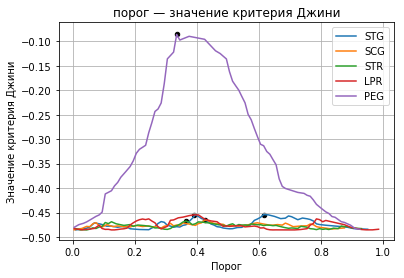

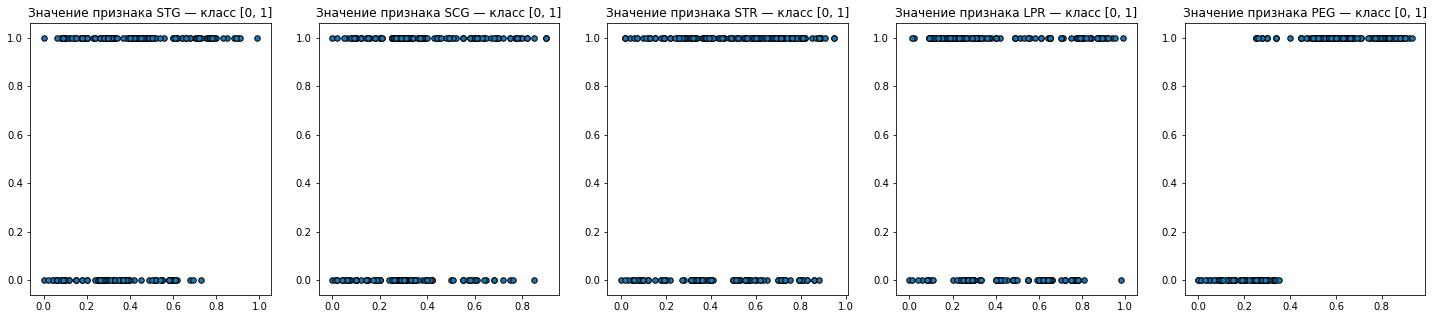

In [25]:
data = pd.read_csv('students.csv', index_col=False)
target = data[' UNS'].values
data = data.drop(' UNS', axis=1)
ax = plt.axes()
plt.title("порог — значение критерия Джини")
ax.set_xlabel(u"Порог")
ax.set_ylabel(u"Значение критерия Джини")
for col in data.columns:
    thresholds, ginis, threshold_best, gini_best = find_best_split(data[col].values, target)
    plt.plot(thresholds, ginis, label=col)
    plt.scatter(threshold_best, gini_best, s=20, c='black')
ax.grid()
ax.legend() 

plt.figure(figsize=(25, 5))
plt.title("Значение признака — класс")
i=1
for col in data.columns:
    plt.subplot(1, 5, i)
    plt.scatter(data[col].values, target, s=30, edgecolor='k')
    plt.title('Значение признака ' + col + ' — класс [0, 1]')
#     plt.ylim([0,1])
    i += 1

__11. (0.5 балла)__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ:** Исходя из кривых значения критерия Джини, деление выборки необходимо производить по признаку PEG, что и подтверждает визуальная оценка scatter-графиков: на графике видно, что почти все объекты со значением признака PEG < 0.4 принадлежат классу 0, т.е. существует порог, позволяющий нам достаточно качественно и информативно разделить выборку. В случае остальных признаков пик значения критерия Джини не ярко выраженнный, из чего следует, что невозможно найти такой же хороший порог, как у признака PEG. Визуальная оценка scatter-графиков этих признаков подтверждает это суждение: на графиках видно, что независимо от значения признаков большое число объектов принадлежит к обоим классам (нет четкой границы). Вид кривой значения критерия Джини для признаков, по которым выборка делится почти идеально, можно охарактеризовать так: кривая должна иметь ярко выраженный экстремум(в нашей реализации максимум), как в случае признака PEG.

__12. (1.5 балла).__

Разберитесь с уже написанным кодом в классе DecisionTree модуля hw3code.py. Найдите ошибки в реализации метода \_fit_node. Напишите функцию \_predict_node.

 Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в [лекции](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture07-trees.pdf) в разделе «Построение дерева». Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

In [137]:
import numpy as np
from collections import Counter

class DecisionTree():
    def __init__(self, feature_types, max_depth=None, min_samples_split=None, min_samples_leaf=None):
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        self._tree = {}
        self._feature_types = feature_types
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf

    def _fit_node(self, sub_X, sub_y, node):
#         if len(sub_y) == 0:
#             return
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return
        
        if sub_X.shape[0] < 2:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(0, sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                counts = Counter(sub_X[:, feature])
                clicks = Counter(sub_X[sub_y == 1, feature])
                ratio = {}
                for key, current_count in counts.items():
                    if key in clicks:
                        current_click = clicks[key]
                    else:
                        current_click = 0
                    ratio[key] = current_click / current_count
                sorted_categories = list(map(lambda x: x[0], sorted(ratio.items(), key=lambda x: x[1])))
                categories_map = dict(zip(sorted_categories, list(range(len(sorted_categories)))))
                feature_vector = np.array(list(map(lambda x: categories_map[x], sub_X[:, feature])))
            else:
                raise ValueError
                
            if np.all(feature_vector == feature_vector[0]):
                continue
                
            _, _, threshold, gini = find_best_split(feature_vector, sub_y)
            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini
                split = feature_vector < threshold

                if feature_type == "real":
                    threshold_best = threshold
                elif feature_type == "categorical":
                    threshold_best = list(map(lambda x: x[0],
                                              filter(lambda x: x[1] < threshold, categories_map.items())))
                else:
                    raise ValueError

        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["categories_split"] = threshold_best
        else:
            raise ValueError
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x, node):
        go_to_left = False
        if node["type"] == "terminal":
            return node["class"]
        feature_best = node["feature_split"]
        if self._feature_types[feature_best] == "real":
            thr = node["threshold"]
            go_to_left = x[feature_best] < thr
#             print(2)
        elif self._feature_types[feature_best] == "categorical":
            thr = node["categories_split"]
            go_to_left = x[feature_best] in thr
        else:
            raise ValueError
#         print(split)
#         print(x[feature_best] , thr)
        if (go_to_left):
            #             print(1)
            return self._predict_node(x, node["left_child"])
        else:
            #             print(2)
            return self._predict_node(x, node["right_child"])
        
    def fit(self, X, y):
        self._fit_node(X, y, self._tree)

    def predict(self, X):
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
        return np.array(predicted)
    
    def get_depth(self):
        return len(self._tree)

    def get_params(self, deep = False):
        return {"feature_types": self._feature_types}

__13. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [128]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

data = pd.read_csv('agaricus-lepiota.data').as_matrix()
data_new = np.zeros(data.shape)

labenc = LabelEncoder()
for i in range(data.shape[1]):
    data_new[:, i] = labenc.fit_transform(data[:, i])

target = data_new[:, 0]
samples = data_new[:, 1:]
    
X_train, X_test, y_train, y_test = train_test_split(samples, target, test_size=0.5, random_state=42)
dt = DecisionTree(["categorical"]*samples.shape[1])
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print('accuracy:', accuracy_score(y_pred, y_test))
print('tree depth:', dt.get_depth())

accuracy: 1.0
tree depth: 5


__15. (1 балл)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [190]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse=False)

mushrooms = data_new[:, 1:]
mushrooms_target = data_new[:, 0]
enc_mushrooms = one_hot_encoder.fit_transform(mushrooms)

data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data',
                         names = np.arange(10)).as_matrix()
labenc = LabelEncoder()
tic_tac_toe = np.zeros(data.shape)
for i in range(0, data.shape[1]):
    tic_tac_toe[:, i] = labenc.fit_transform(data[:, i])
tic_tac_toe_target = tic_tac_toe[:, -1]
tic_tac_toe = tic_tac_toe[:, :-1]
enc_tic_tac_toe = one_hot_encoder.fit_transform(tic_tac_toe)

data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data',
                         names = np.arange(7)).as_matrix()
data[(data == 'acc') + (data == 'unacc')] = 0
data[(data == 'good') + (data == 'vgood')] = 1
labenc = LabelEncoder()
cars = np.zeros(data.shape)
for i in range(0, data.shape[1]):
    cars[:, i] = labenc.fit_transform(data[:, i])
cars_target = cars[:, -1]
cars = cars[:, :-1]
enc_cars = one_hot_encoder.fit_transform(cars)

data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data',
                         names = np.arange(9)).as_matrix()
data[(data[:, -1] == 'not_recom') + (data[:, -1] == 'recommend')] = 0
data[(data[:, -1] == 'very_recom') + (data[:, -1] == 'priority') 
     + (data[:, -1] == 'spec_prior')] = 1
labenc = LabelEncoder()
nursery = np.zeros(data.shape)
for i in range(0, data.shape[1]):
    nursery[:, i] = labenc.fit_transform(data[:, i])
nursery_target = nursery[:, -1]
nursery = nursery[:, :-1]
enc_nursery = one_hot_encoder.fit_transform(nursery)

In [191]:
results = pd.DataFrame(index=["mushrooms", "tic-tac-toe", "cars", "nursery"], 
                       columns=["all real", "all categorical", "all real + OHE", "DesicionTreeClassifier"])

In [192]:
#mushrooms
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, accuracy_score

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
# cv = KFold(n=mushrooms.shape[0], n_folds=10, shuffle=True, random_state=42)
# cv = KFold(n_splits=10, shuffle=True, random_state=42)

#DecisionTree, считающий все признаки вещественными
dt = DecisionTree(["real"]*mushrooms.shape[1])
mushrooms_dt_real = cross_val_score(dt,  X=mushrooms, y=mushrooms_target,
                                    scoring=make_scorer(accuracy_score), cv=cv)
results.iloc[0,0] = mushrooms_dt_real.mean()

#DecisionTree, считающий все признаки категориальными
dt = DecisionTree(["categorical"]*mushrooms.shape[1])
mushrooms_dt_categ = cross_val_score(dt,  X=mushrooms, y=mushrooms_target,
                                    scoring=make_scorer(accuracy_score), cv=cv)
results.iloc[0,1] = mushrooms_dt_categ.mean()

#DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
dt = DecisionTree(["real"]*enc_mushrooms.shape[1])
mushrooms_dt_real_enc = cross_val_score(dt,  X=enc_mushrooms, y=mushrooms_target,
                                    scoring=make_scorer(accuracy_score), cv=cv)
results.iloc[0,2] = mushrooms_dt_real_enc.mean()

#DecisionTreeClassifier из sklearn
dt = DecisionTreeClassifier()
mushrooms_dt_sklearn = cross_val_score(dt,  X=mushrooms, y=mushrooms_target,
                                    scoring=make_scorer(accuracy_score), cv=cv)
results.iloc[0,3] = mushrooms_dt_sklearn.mean()

In [193]:
#tic-tac-toe

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
# cv = KFold(n=mushrooms.shape[0], n_folds=10, shuffle=True, random_state=42)
# cv = KFold(n_splits=10, shuffle=True, random_state=42)

#DecisionTree, считающий все признаки вещественными
dt = DecisionTree(["real"]*tic_tac_toe.shape[1])
tic_tac_toe_dt_real = cross_val_score(dt,  X=tic_tac_toe, y=tic_tac_toe_target,
                                    scoring=make_scorer(accuracy_score), cv=cv)
results.iloc[1,0] = tic_tac_toe_dt_real.mean()

#DecisionTree, считающий все признаки категориальными
dt = DecisionTree(["categorical"]*tic_tac_toe.shape[1])
tic_tac_toe_dt_categ = cross_val_score(dt,  X=tic_tac_toe, y=tic_tac_toe_target,
                                    scoring=make_scorer(accuracy_score), cv=cv)
results.iloc[1,1] = tic_tac_toe_dt_categ.mean()

#DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
dt = DecisionTree(["real"]*enc_tic_tac_toe.shape[1])
tic_tac_toe_dt_real_enc = cross_val_score(dt,  X=enc_tic_tac_toe, y=tic_tac_toe_target,
                                    scoring=make_scorer(accuracy_score), cv=cv)
results.iloc[1,2] = tic_tac_toe_dt_real_enc.mean()

#DecisionTreeClassifier из sklearn
dt = DecisionTreeClassifier()
tic_tac_toe_dt_sklearn = cross_val_score(dt,  X=tic_tac_toe, y=tic_tac_toe_target,
                                    scoring=make_scorer(accuracy_score), cv=cv)
results.iloc[1,3] = tic_tac_toe_dt_sklearn.mean()

In [194]:
#cars

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
# cv = KFold(n=mushrooms.shape[0], n_folds=10, shuffle=True, random_state=42)
# cv = KFold(n_splits=10, shuffle=True, random_state=42)

#DecisionTree, считающий все признаки вещественными
dt = DecisionTree(["real"]*cars.shape[1])
cars_dt_real = cross_val_score(dt,  X=cars, y=cars_target,
                                    scoring=make_scorer(accuracy_score), cv=cv)
results.iloc[2,0] = cars_dt_real.mean()

#DecisionTree, считающий все признаки категориальными
dt = DecisionTree(["categorical"]*cars.shape[1])
cars_dt_categ = cross_val_score(dt,  X=cars, y=cars_target,
                                    scoring=make_scorer(accuracy_score), cv=cv)
results.iloc[2,1] = cars_dt_categ.mean()

#DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
dt = DecisionTree(["real"]*enc_cars.shape[1])
cars_dt_real_enc = cross_val_score(dt,  X=enc_cars, y=cars_target,
                                    scoring=make_scorer(accuracy_score), cv=cv)
results.iloc[2,2] = cars_dt_real_enc.mean()

#DecisionTreeClassifier из sklearn
dt = DecisionTreeClassifier()
cars_dt_sklearn = cross_val_score(dt,  X=cars, y=cars_target,
                                    scoring=make_scorer(accuracy_score), cv=cv)
results.iloc[2,3] = cars_dt_sklearn.mean()

In [195]:
#nursery

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
# cv = KFold(n=mushrooms.shape[0], n_folds=10, shuffle=True, random_state=42)
# cv = KFold(n_splits=10, shuffle=True, random_state=42)

#DecisionTree, считающий все признаки вещественными
dt = DecisionTree(["real"]*nursery.shape[1])
nursery_dt_real = cross_val_score(dt,  X=nursery, y=nursery_target,
                                    scoring=make_scorer(accuracy_score), cv=cv)
results.iloc[3,0] = nursery_dt_real.mean()

#DecisionTree, считающий все признаки категориальными
dt = DecisionTree(["categorical"]*nursery.shape[1])
nursery_dt_categ = cross_val_score(dt,  X=nursery, y=nursery_target,
                                    scoring=make_scorer(accuracy_score), cv=cv)
results.iloc[3,1] = nursery_dt_categ.mean()

#DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
dt = DecisionTree(["real"]*enc_nursery.shape[1])
nursery_dt_real_enc = cross_val_score(dt,  X=enc_nursery, y=nursery_target,
                                    scoring=make_scorer(accuracy_score), cv=cv)
results.iloc[3,2] = nursery_dt_real_enc.mean()

#DecisionTreeClassifier из sklearn
dt = DecisionTreeClassifier()
nursery_dt_sklearn = cross_val_score(dt,  X=nursery, y=nursery_target,
                                    scoring=make_scorer(accuracy_score), cv=cv)
results.iloc[3,3] = nursery_dt_sklearn.mean()

In [196]:
results

,all real,all categorical,all real + OHE,DesicionTreeClassifier
mushrooms,1,1,1,1
tic-tac-toe,0.868458,0.951917,0.951917,0.877899
cars,0.99305,0.992475,0.988974,0.991312
nursery,1,1,1,1


__16. (0.5 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:** Можно сделать вывод, что результаты ранжируются почти одинаково, однако можно увидеть отличия на различных наборах данных. Результаты для выборок mushrooms и nursery показали наилучший результат. В используемых данных все признаки считались категориальными(следует из файла *.names). Самый плохой результат показало дерево с вещественными признаками на tic-tac-toe. При различной кодировке категориальных признаков с помощью LabelEncoder можно повлиять на работу алгоритмов, использующие вещественные признаки вместо категориальных.

### III. Композиции деревьев
#### Задача 4. Сравнение композиционных методов над решающими деревьями
__17. (0.5 балла)__

Загрузите датасет из соревнования [BNP Paribas Cardif Claims Management](https://www.kaggle.com/c/bnp-paribas-cardif-claims-management/leaderboard). Возьмите из него первые 10к объектов, оставьте только вещественные признаки, а пропуски замените нулями. Разбейте выборку на обучение и контроль в соотношении 7:3.

1. С помощью cross_val_score с cv=3 оцените качество (accuracy) следующих классификаторов на обучающей выборке:
    * DecisionTreeClassifier
    * BaggingClassifier со 100 деревьями
    * RandomForestClassifier со 100 деревьями
    
Значение получается шумное, но в целом у вас должно получиться, что качество возрастает с каждым следующим алгоритмом (если это не так, то посмотрите как ведут себя алгоритмы с разными сидами в кроссвалидации и самих алгоритмах). Этот пример демонстрирует, что RandomForest — это более сложный алгоритм, чем бэггинг. 

In [ ]:
import pandas as pd

data = pd.read_csv('train.csv', index_col=False, nrows=10000)
print(len(data.index))
target = data["target"]
data = data.drop("target", axis=1)
data =  data.select_dtypes(include=['float64'])
data = data.fillna(0)

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=42)

In [25]:
cv = KFold(n_splits=3, shuffle=True, random_state=42)
dt = DecisionTreeClassifier()
DT_score = cross_val_score(dt,  X=X_train, y=y_train,
                                    scoring=make_scorer(accuracy_score), cv=cv).mean()
dt = BaggingClassifier(n_estimators=100)
BC_score = cross_val_score(dt,  X=X_train, y=y_train,
                                    scoring=make_scorer(accuracy_score), cv=cv).mean()
dt = RandomForestClassifier(n_estimators=100)
RFC_score = cross_val_score(dt,  X=X_train, y=y_train,
                                    scoring=make_scorer(accuracy_score), cv=cv).mean()
print("Desicion Tree score: ", DT_score)
print("Bagging Clasifier score: ", BC_score)
print("Random Forest Classifier score: ", RFC_score)

Desicion Tree score:  0.660857537122
Bagging Clasifier score:  0.753571540946
Random Forest Classifier score:  0.755714214529


#### Задача 5. Число деревьев в случайном лесе
В этой задаче мы рассмотрим, переобучаются ли композиционные алгоритмы с увеличением числа деревьев.

__18. (0.5 балла)__

Переберите значения от 20 до 1000-5000 деревьев с шагом 20, посчитайте accuracy на тестовой выборке для каждого числа деревьев и постройте график зависимости качества от числа деревьев.

Рекомендация.

Если каждый раз обучать RandomForest с нуля, придётся обучить в общей сумме $20 + 200 + \ldots + 5000$ деревьев.
Однако, как мы знаем, деревья в случайных лесах строятся независимо и параллельно, поэтому можно обучить всего 5000 деревьев.

Для этого в при создании объекта класса RandomForestClassifier нужно указать в том числе warm_start=True. Затем обучить алгоритм с помощью метода fit, использовать метод predict для классификации. После этого с помощью метода set_params изменить параметр n_estimators. Если к полученному объекту применить метод fit, внутри него будет обучаться только недостающее число деревьев.

Переобучается ли случайный лес с увеличением числа деревьев?

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ


#### Задача 6. Обучение градиентного бустинга

__19. (1 балл)__

А теперь попробуйте обучить на тех же данных xgboost — одну из реализаций градиентного бустинга. Подберите параметры на обучающем множестве с помощью кроссвалидации (хорошая [статья](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/) про тюнинг параметров xgboost). 

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ


**Оценка:** 8